In [506]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
import uuid
from deepface import DeepFace
from typing import Dict, Tuple, List
import time
# from pillow_heif import open_heif
from pillow_heif import register_heif_opener
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os


In [507]:
# Initialize face analysis models
app_scrfd = FaceAnalysis(name='buffalo_s', detectors=['SCRFD'])
app_retina = FaceAnalysis(name='buffalo_l', detectors=['RetinaFace'])

app_scrfd.prepare(ctx_id=0, det_size=(640, 640))
app_retina.prepare(ctx_id=0, det_size=(640, 640))

facenet_model = "Facenet512"

# In-memory face database
face_db = {}  # {"name_or_id": embedding_vector}

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/adityapatil/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['Non

In [508]:
image_dir = "/Users/adityapatil/photos_backup"
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg", ".heic"))][:1000]

In [ ]:
for image in image_paths:

In [509]:
image_path = "/Users/adityapatil/photos_backup/GFNT7008.JPG"
next_image = "/Users/adityapatil/photos_backup/IMG_3389.HEIC"
# next_image = "/Users/adityapatil/photos_backup/IMG_6920.HEIC"

In [510]:
# Enable HEIC support
register_heif_opener()

# img = cv2.imread(image_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read image using PIL
image = Image.open(image_path)  # Supports HEIC, JPEG, PNG, etc.
image = image.convert("RGB")  # Convert to RGB if needed
img = np.array(image)

# Read image using PIL
image2 = Image.open(next_image)  # Supports HEIC, JPEG, PNG, etc.
image2 = image2.convert("RGB")  # Convert to RGB if needed
img2 = np.array(image2)


# heif_file = open_heif(next_image)
# # Convert to a PIL Image
# image_pil = Image.frombytes(
#     heif_file.mode, 
#     heif_file.size, 
#     heif_file.data,
#     "raw",
#     heif_file.mode
# )

# # Convert PIL Image to OpenCV format
# img2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

In [511]:
image = img

start_time = time.time()
scrfd_faces = app_scrfd.get(image)
scrfd_time = time.time() - start_time


start_time = time.time()
retina_faces = app_retina.get(image)
retina_time = time.time() - start_time

# ArcFace embeddings
start_time = time.time()
arcface_embeddings = []
for face in scrfd_faces:
    embedding = face.embedding  # ArcFace embedding from MobileFaceNet
    arcface_embeddings.append(embedding)
arcface_time = time.time() - start_time

# FaceNet embeddings using DeepFace
start_time = time.time()
facenet_embeddings = []
for face in scrfd_faces:
    # Crop face
    bbox = face.bbox.astype(int)
    # Ensure bbox is within image bounds
    bbox = [
        max(0, bbox[0]), max(0, bbox[1]),
        min(image.shape[1], bbox[2]), min(image.shape[0], bbox[3])
    ]
    face_img = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    if face_img.size == 0:  # Skip if cropped area is empty
        continue
    # Convert to BGR for DeepFace
    face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)
    try:
        # Generate embedding using DeepFace
        embedding = DeepFace.represent(
            img_path=face_img,
            model_name=facenet_model,
            enforce_detection=False,  # Skip detection since we already have the face
            detector_backend="skip"   # Avoid re-detection
        )[0]["embedding"]
        facenet_embeddings.append(np.array(embedding))
    except Exception as e:
        print(f"Error generating FaceNet embedding: {e}")
        continue
facenet_time = time.time() - start_time

times = (scrfd_time, retina_time, arcface_time, facenet_time)

In [439]:
# Performance comparison
print("Performance Comparison:")
print(f"SCRFD Detection Time: {times[0]:.6f}s, Faces detected: {len(scrfd_faces)}")
print(f"RetinaFace Detection Time: {times[1]:.6f}s, Faces detected: {len(retina_faces)}")
print(f"ArcFace Embedding Time: {times[2]:.6f}s")
print(f"FaceNet Embedding Time: {times[3]:.6f}s")

Performance Comparison:
SCRFD Detection Time: 0.254033s, Faces detected: 4
RetinaFace Detection Time: 0.597202s, Faces detected: 4
ArcFace Embedding Time: 0.000044s
FaceNet Embedding Time: 0.278116s


In [440]:
next_id = 0
face_database: Dict[int, Dict[str, any]] = {}


In [441]:
for i, embedding in enumerate(arcface_embeddings):
    face_id = next_id
    face_database[face_id] = {
        'embedding': embedding,
        'name': f"Person_{face_id}"
    }
    next_id += 1

In [442]:
print(len(face_database[0]['embedding']))
print(len(arcface_embeddings[0]))
print(len(facenet_embeddings[0]))


512
512
512


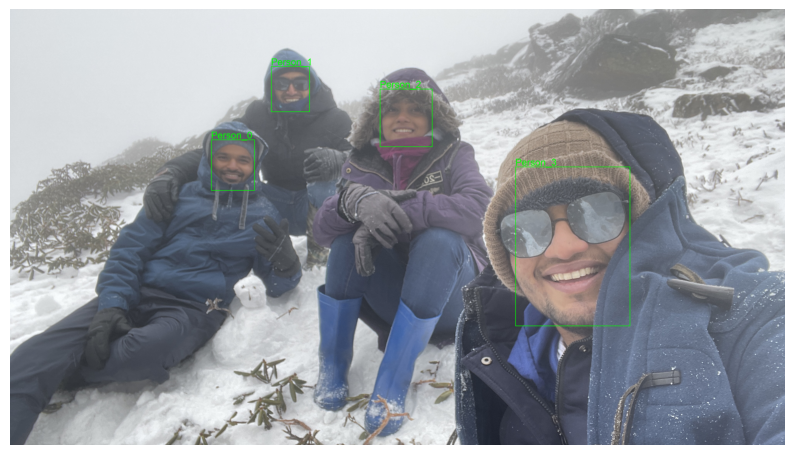

In [443]:
# Load image using PIL
image = Image.open(image_path)  # Supports HEIC, JPEG, PNG, etc.
image = image.convert("RGB")  # Convert to RGB if needed

# Create a drawing context
draw = ImageDraw.Draw(image)

# Load a font (optional, requires a valid .ttf file)
# You can use `ImageFont.load_default()` if you don't have a custom font

font_size=50
for i, face in enumerate(scrfd_faces):
    bbox = face['bbox']  # Assuming bbox format: [x1, y1, x2, y2]
    embedding = face['embedding']  # Extract the embedding for this face

    # Find the closest match in the face_database
    best_match_id = None
    max_similarity = -1

    for face_id, data in face_database.items():
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))  # Euclidean distance
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_id = face_id

    # Get the name of the best match
    name = face_database.get(best_match_id, {}).get('name', 'Unknown')

    # Draw bounding box
    x1, y1, x2, y2 = map(int, bbox)

    font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", font_size)  # Adjust font size as needed

    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)

    # Put text with name
    text_position = (x1, max(y1-font_size-1, 0))  # Position the text above the box
    draw.text(text_position, name, fill=(0, 255, 0), font=font)

# Convert to NumPy array for matplotlib display
print_img = np.array(image)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(print_img)
plt.axis("off")
plt.show()

In [444]:
names = ["Aditya", "Jinay", "Shruti", "Yash"]
for i in range(len(face_database)):
    face_database[i]['name'] = names[i]


In [445]:
names = [data['name'] for data in face_database.values()]
print(names)

['Aditya', 'Jinay', 'Shruti', 'Yash']


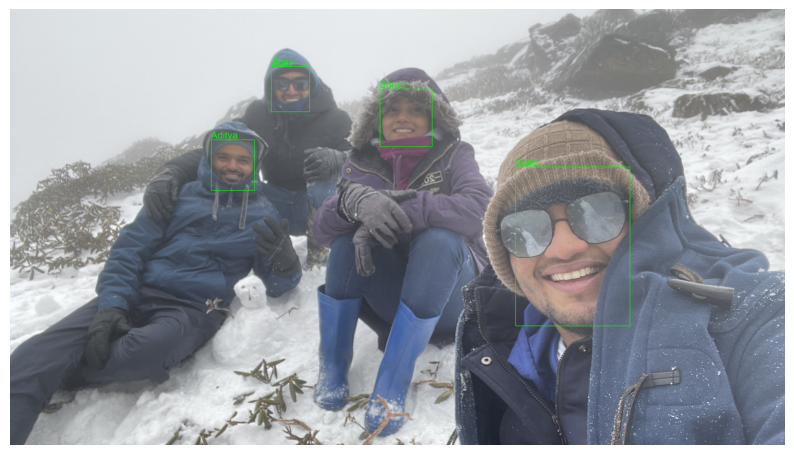

In [446]:
# Load image using PIL
image = Image.open(image_path)  # Supports HEIC, JPEG, PNG, etc.
image = image.convert("RGB")  # Convert to RGB if needed

# Create a drawing context
draw = ImageDraw.Draw(image)

font_size=50
for i, face in enumerate(scrfd_faces):
    bbox = face['bbox']  # Assuming bbox format: [x1, y1, x2, y2]
    embedding = face['embedding']  # Extract the embedding for this face

    # Find the closest match in the face_database
    best_match_id = None
    max_similarity = -1

    for face_id, data in face_database.items():
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))  # Euclidean distance
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_id = face_id

    # Get the name of the best match
    name = face_database.get(best_match_id, {}).get('name', 'Unknown')

    # Draw bounding box
    x1, y1, x2, y2 = map(int, bbox)

    font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", font_size)  # Adjust font size as needed

    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)

    # Put text with name
    text_position = (x1, max(y1-font_size-1, 0))  # Position the text above the box
    draw.text(text_position, name, fill=(0, 255, 0), font=font)

# Convert to NumPy array for matplotlib display
print_img = np.array(image)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(print_img)
plt.axis("off")
plt.show()

In [447]:
scrfd_faces = app_scrfd.get(img2)
arcface_embeddings2 = []
for face in scrfd_faces:
    embedding = face.embedding  # ArcFace embedding from MobileFaceNet
    arcface_embeddings2.append(embedding)

In [448]:
print(len(face_database))
print(len(arcface_embeddings2))
add_new: Dict[int, Dict[str, any]] = {}
for i, embedding in enumerate(arcface_embeddings2):
    found = False  # Track if a match is found

    for face_id, data in face_database.items():
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))
        # print(similarity)
        if similarity > 0.21:
            print(f"Found {data['name']} in the image with similarity {similarity}")
            
            found = True
            break  # Stop checking further once a match is found
    # print(found)
    # If no match is found, add the new face
    if not found:
        face_id = next_id
        add_new[face_id] = {
            'embedding': embedding,
            'name': f"Person_{face_id}"
        }
        next_id += 1  # Increment only when a new face is added
face_database.update(add_new)

4
6
Found Shruti in the image with similarity 0.3819376230239868
Found Aditya in the image with similarity 0.227909117937088
Found Jinay in the image with similarity 0.3376771807670593
Found Yash in the image with similarity 0.48196378350257874


In [449]:
names = [data['name'] for data in face_database.values()]
print(names)

['Aditya', 'Jinay', 'Shruti', 'Yash', 'Person_4', 'Person_5']


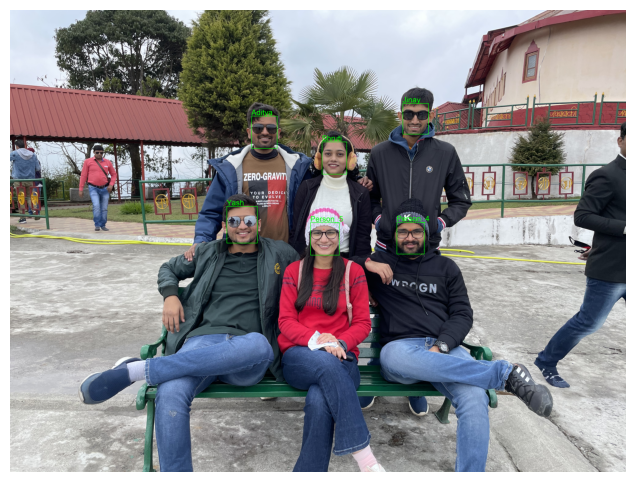

In [450]:
# import matplotlib.pyplot as plt

# Assuming you have the image loaded as 'image'
# And scrfd_faces contains detected face bounding boxes
# And face_database stores embeddings with names

# Read image using PIL
image2 = Image.open(next_image).convert("RGB")  # Convert to RGB if needed

# Create a drawing context
draw = ImageDraw.Draw(image2)

font_size=50
for i, face in enumerate(scrfd_faces):
    bbox = face['bbox']  # Assuming bbox format: [x1, y1, x2, y2]
    embedding = face['embedding']  # Extract the embedding for this face

    # Find the closest match in the face_database
    best_match_id = None
    max_similarity = -1

    for face_id, data in face_database.items():
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))  # Euclidean distance
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_id = face_id

    # Get the name of the best match
    name = face_database.get(best_match_id, {}).get('name', 'Unknown')

    # Draw bounding box
    x1, y1, x2, y2 = map(int, bbox)

    font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", font_size)  # Adjust font size as needed

    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)

    # Put text with name
    text_position = (x1, max(y1-font_size-1, 0))  # Position the text above the box
    draw.text(text_position, name, fill=(0, 255, 0), font=font)

# Convert to NumPy array for matplotlib display
print_img2 = np.array(image2)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(print_img2)
plt.axis("off")
plt.show()

### Testing facenet accuracy on occlusions

In [493]:
next_id = 0
face_database: Dict[int, Dict[str, any]] = {}


In [ ]:
scrfd_faces = app_scrfd.get(img)
# ArcFace embeddings
arcface_embeddings = []
for face in scrfd_faces:
    embedding = face.embedding  # ArcFace embedding from MobileFaceNet
    arcface_embeddings.append(embedding)


In [498]:

for i, embedding in enumerate(arcface_embeddings):
    face_id = next_id
    face_database[face_id] = {
        'embedding': embedding,
        'name': f"Person_{face_id}"
    }
    next_id += 1

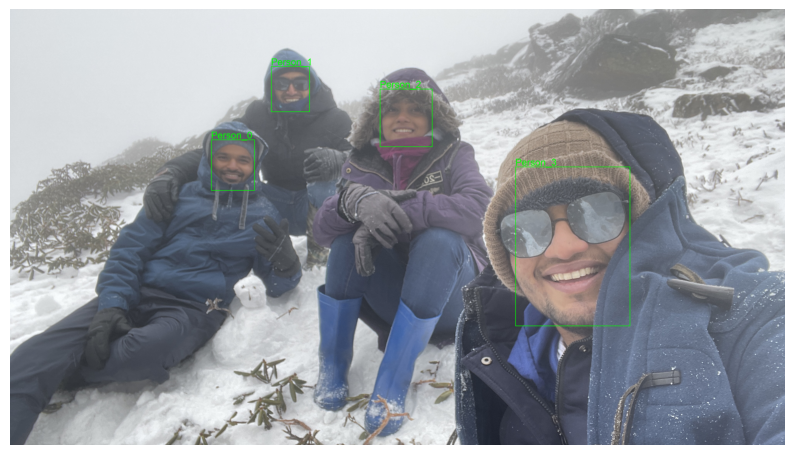

In [468]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace

# Load image using PIL
image = Image.open(image_path)  # Supports HEIC, JPEG, PNG, etc.
image = image.convert("RGB")  # Convert to RGB if needed
image_np = np.array(image)  # Convert to NumPy array for processing

# Create a drawing context
draw = ImageDraw.Draw(image)

# Load a font (optional, requires a valid .ttf file)
font_size = 50
font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Arial.ttf", font_size)  # Adjust font size as needed

facenet_embeddings = []
for face in scrfd_faces:
    bbox = face.bbox.astype(int)
    bbox = [
        max(0, bbox[0]), max(0, bbox[1]),
        min(image_np.shape[1], bbox[2]), min(image_np.shape[0], bbox[3])
    ]
    face_img = image_np[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    if face_img.size == 0:
        continue
    face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)
    try:
        embedding = DeepFace.represent(
            img_path=face_img,
            model_name="Facenet512",
            enforce_detection=False,
            detector_backend="skip"
        )[0]["embedding"]
        facenet_embeddings.append((face, np.array(embedding, dtype=np.float32)))  # Ensure embedding is a NumPy array
    except Exception as e:
        print(f"Error generating FaceNet embedding: {e}")
        continue

for face, embedding in facenet_embeddings:
    bbox = face.bbox.astype(int)
    x1, y1, x2, y2 = map(int, bbox)
    
    # Find the closest match in the face_database
    best_match_id = None
    max_similarity = -1
    embedding = np.array(embedding, dtype=np.float32)  # Ensure embedding is a NumPy array
    for face_id, data in face_database.items():
        stored_embedding = np.array(data['embedding'], dtype=np.float32)  # Ensure stored embedding is a NumPy array
        similarity = np.dot(embedding, stored_embedding) / (np.linalg.norm(embedding) * np.linalg.norm(stored_embedding))
        if similarity > max_similarity:
            max_similarity = similarity
            best_match_id = face_id
    
    name = face_database.get(best_match_id, {}).get('name', 'Unknown')
    
    # Draw bounding box and name
    draw.rectangle([x1, y1, x2, y2], outline=(0, 255, 0), width=3)
    text_position = (x1, max(y1 - font_size - 1, 0))
    draw.text(text_position, name, fill=(0, 255, 0), font=font)

# Convert to NumPy array for matplotlib display
print_img = np.array(image)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(print_img)
plt.axis("off")
plt.show()


In [469]:
# Read image using PIL
image2 = Image.open(next_image)  # Supports HEIC, JPEG, PNG, etc.
image2 = image2.convert("RGB")  # Convert to RGB if needed
img2 = np.array(image2)

scrfd_faces = app_scrfd.get(img2)
facenet_embeddings2 = []

for face in scrfd_faces:
    bbox = face.bbox.astype(int)
    bbox = [
        max(0, bbox[0]), max(0, bbox[1]),
        min(img2.shape[1], bbox[2]), min(img2.shape[0], bbox[3])
    ]
    face_img = img2[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    if face_img.size == 0:
        continue
    face_img = cv2.cvtColor(face_img, cv2.COLOR_RGB2BGR)
    try:
        embedding = DeepFace.represent(
            img_path=face_img,
            model_name="Facenet512",
            enforce_detection=False,
            detector_backend="skip"
        )[0]["embedding"]
        facenet_embeddings2.append((face, np.array(embedding, dtype=np.float32)))  # Ensure embedding is a NumPy array
    except Exception as e:
        print(f"Error generating FaceNet embedding: {e}")
        continue

In [471]:
names = ["Aditya", "Jinay", "Shruti", "Yash"]
for i in range(len(face_database)):
    face_database[i]['name'] = names[i]

In [481]:
for i in range(len(face_database)):
    print(face_database[i]['name'])

print(facenet_embeddings2)

Aditya
Jinay
Shruti
Yash
[({'bbox': array([2041.4454,  862.59  , 2205.552 , 1075.1475], dtype=float32), 'kps': array([[2084.5347 ,  941.85254],
       [2161.499  ,  943.3899 ],
       [2121.141  ,  985.96783],
       [2088.0752 , 1016.6707 ],
       [2153.777  , 1017.9438 ]], dtype=float32), 'det_score': 0.87393916, 'landmark_3d_68': array([[ 2.04201904e+03,  9.39053162e+02,  1.18216316e+02],
       [ 2.04363684e+03,  9.62857056e+02,  1.14631355e+02],
       [ 2.04487524e+03,  9.86916504e+02,  1.09326271e+02],
       [ 2.04749207e+03,  1.00950641e+03,  9.97341156e+01],
       [ 2.05223169e+03,  1.02939868e+03,  8.13083191e+01],
       [ 2.06194019e+03,  1.04421692e+03,  6.53035355e+01],
       [ 2.07438721e+03,  1.05512219e+03,  5.12769318e+01],
       [ 2.08921411e+03,  1.06408521e+03,  3.35731125e+01],
       [ 2.11405981e+03,  1.07285791e+03,  2.14164944e+01],
       [ 2.14140942e+03,  1.06733948e+03,  2.96642590e+01],
       [ 2.16353369e+03,  1.05892725e+03,  4.66616516e+01],
    

In [ ]:
print(len(face_database))
print(len(facenet_embeddings2))
add_new: Dict[int, Dict[str, any]] = {}
for i, embedding_entry in enumerate(facenet_embeddings2):
    found = False  # Track if a match is found
    embedding = embedding_entry[0]['embedding']

    for face_id, data in face_database.items():
        # print(len(embedding))
        # print(len(data['embedding']))
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))
        # print(similarity)
        if similarity > 0.05:
            print(f"Found {data['name']} in the image with similarity {similarity}")
            found = True
            # break  # Stop checking further once a match is found
        else:
            print(f"Not found. Similarity = {similarity}")

    # print(found)
    # If no match is found, add the new face
    # if not found:
    #     face_id = next_id
    #     add_new[face_id] = {
    #         'embedding': embedding,
    #         'name': f"Person_{face_id}"
    #     }
    #     next_id += 1  # Increment only when a new face is added
# face_database.update(add_new)

## Testing heavier Retinaface and Arcface (Resnet based)

In [512]:
next_id = 0
face_database: Dict[int, Dict[str, any]] = {}

In [513]:
image = Image.open(image_path)  # Supports HEIC, JPEG, PNG, etc.
image = image.convert("RGB")  # Convert to RGB if needed
img = np.array(image)

# Read image using PIL
image2 = Image.open(next_image)  # Supports HEIC, JPEG, PNG, etc.
image2 = image2.convert("RGB")  # Convert to RGB if needed
img2 = np.array(image2)

In [514]:
retina_faces = app_retina.get(img)

# ArcFace embeddings
arcface_embeddings = []
for face in retina_faces:
    embedding = face.embedding  # ArcFace embedding from MobileFaceNet
    arcface_embeddings.append(embedding)


In [515]:
for i, embedding in enumerate(arcface_embeddings):
    face_id = next_id
    face_database[face_id] = {
        'embedding': embedding,
        'name': f"Person_{face_id}"
    }
    next_id += 1

In [516]:
names = ["Aditya", "Jinay", "Shruti", "Yash"]
for i in range(len(face_database)):
    face_database[i]['name'] = names[i]


In [517]:
retina_faces = app_retina.get(img2)
arcface_embeddings2 = []
for face in retina_faces:
    embedding = face.embedding  # ArcFace embedding from MobileFaceNet
    arcface_embeddings2.append(embedding)

In [518]:
print(len(face_database))
print(len(arcface_embeddings2))
add_new: Dict[int, Dict[str, any]] = {}
for i, embedding in enumerate(arcface_embeddings2):
    found = False  # Track if a match is found

    for face_id, data in face_database.items():
        similarity = np.dot(embedding, data['embedding']) / (np.linalg.norm(embedding) * np.linalg.norm(data['embedding']))
        # print(similarity)
        if similarity > 0.21:
            print(f"Found {data['name']} in the image with similarity {similarity}")
            
            found = True
            break  # Stop checking further once a match is found
    # print(found)
    # If no match is found, add the new face
#     if not found:
#         face_id = next_id
#         add_new[face_id] = {
#             'embedding': embedding,
#             'name': f"Person_{face_id}"
#         }
#         next_id += 1  # Increment only when a new face is added
# face_database.update(add_new)

4
7
Found Yash in the image with similarity 0.49745994806289673
Found Jinay in the image with similarity 0.39617404341697693
Found Shruti in the image with similarity 0.5334287881851196
Found Aditya in the image with similarity 0.38867220282554626
